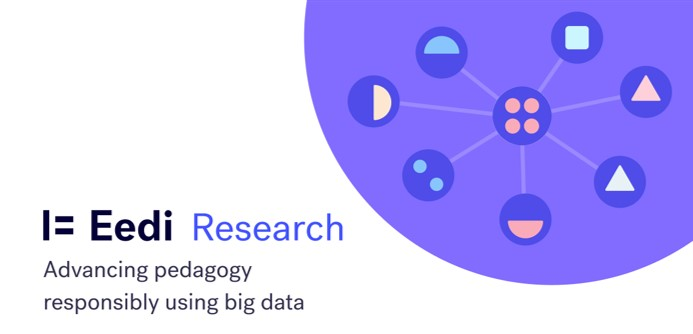

**Simple baseline and EDA for Kaggle Eedi Competition.**

##### Please don't forget to upvote if you like my work ! 😉

___
___
# **Librairies**

In [ ]:
import numpy as np
import pandas as pd
import random
import os
random.seed(10)

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb

from tqdm import tqdm
import joblib

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_percentage_error
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

___
___
# **Utils**
Functions to compute_cv ...

In [ ]:
def map25(true_ids, predictions):
    for i, pred in enumerate(predictions[:25]):
        if pred in true_ids :
            return 1/(i+1)
    return 0

def get_sorted_predictions(df_values):
    # Sort values by y_pred (decreasing order)
    return df_values.sort_values(by = ['y_pred'], ascending=False)['Misconception_candidate'].values[:25]

def get_sorted_predictions_for_submission(df_values):
    # Sort values by y_pred (decreasing order)
    values = df_values.sort_values(by = ['y_pred'], ascending=False)['Misconception_candidate'].values[:25]
    return " ".join(map(str, values))

def compute_cv(df):
    
    # Use tuple instead of list (hashable type)
    df['list_of_Misconceptions'] = df['list_of_Misconceptions'].apply(tuple)
    
    # Create one line per question & answer
    df_cv = df.groupby(['ConstructName', 'list_of_Misconceptions']).apply(get_sorted_predictions).to_frame().reset_index()

    # Rename for clarity
    df_cv.columns = ["ConstructName", "list_of_Misconceptions", "misconceptionID_predictions"]
        
    # Get score for each line
    df_cv['score'] = df_cv.apply(lambda row : map25(row['list_of_Misconceptions'], row['misconceptionID_predictions']), axis=1)
    
    # Return mean score
    return df_cv['score'].mean()

___
___
# **Open data**

In [ ]:
# Train
df_train = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")

# Show
print(df_train.shape)
df_train.head(2)

In [ ]:
# Test
df_test = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv")

# Show
print(df_test.shape)
df_test.head(3)

In [ ]:
# Misconception mapping
misconception_mapping = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")

# Show
print(misconception_mapping.shape)
misconception_mapping.head()

### **Create tfidf features for misconception_mapping**

In [ ]:
# Create tfidf vectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01, # a term must appear in at least x% of the documents to be considered.
                            max_df=0.98, # a term must appear in less than x% of the documents to be considered.
                            max_features=600,
                            #stop_words = 'english',
                           )

# Fit and save vectorizer
tfidf = tfidf_vec.fit_transform(misconception_mapping['MisconceptionName'].values)
joblib.dump(tfidf_vec, "tfidf_vec_MisconceptionName.joblib")

# Add tfidf features to df
col_names = [f'tfidf_MisconceptionName_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
misconception_mapping = pd.concat([misconception_mapping, tfidf_df], axis=1)

# Show
print(misconception_mapping.shape)
misconception_mapping.head(2)

___
___
# **Create a dataframe for modelisation**

### **1. Initialize a df with one line per misconception**

In [ ]:
def get_MisconceptionId(row) :
    cols = [f'Misconception{letter}Id' for letter in ['A', 'B', 'C', 'D']]
    return [int(row[x].values[0]) for x in cols if not(pd.isna(row[x].values[0]))]

# Initialize df
df = df_train.groupby(['SubjectName', 'ConstructName', 'QuestionText']).apply(get_MisconceptionId).to_frame().reset_index()

# Rename for clarity
df = df.rename(columns = {0 : 'list_of_Misconceptions'})

# Show
print(df.shape)
df.head()

### **2. Add random false misconceptions to train a binary classifier**

In [ ]:
# Approximate number of candidates.
# => The higher the number, the better the score (and the lower but the more real CV), and the longer the training
n_candidates = 5

# Create a list of candidates
df['Misconception_candidate'] = df['list_of_Misconceptions'].apply(lambda L : L + sorted(set([random.randint(1, 2586) for _ in range(n_candidates)])))

# Show
print(df.shape)
df.head(2)

### **3. Create Features (TF-IDF)**

In [ ]:
%%time

# Extract tf-idf features for these 3 columns
for col in ['SubjectName', 'ConstructName', 'QuestionText'] :
    
    # Create corpus of texts
    if col == 'MisconceptionName' :
        corpus = misconception_mapping[col].values
    else :
        corpus = list(set(df_train[col].values) | set(df_test[col].values))
        
    # Create tfidf vectorizer
    tfidf_vec = TfidfVectorizer(min_df=0.01, # a term must appear in at least x% of the documents to be considered.
                                max_df=0.98, # a term must appear in less than x% of the documents to be considered.
                                max_features=600,
                                #stop_words = 'english',
                               )
    
    # Fit and save vectorizer
    tfidf_vec.fit(corpus)
    joblib.dump(tfidf_vec, f"tfidf_vec_{col}.joblib")
    
    # Transform df column
    tfidf = tfidf_vec.transform(df[col].values)
    
    # Add tfidf features to df
    col_names = [f'tfidf_{col}_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
    df = pd.concat([df, tfidf_df], axis=1)
    
# Show
print(df.shape)
df.head(1)

### **Explode list to have one row per candidate**

In [ ]:
%%time

# Explode list of candidates (to have one row per candidate)
df = df.explode('Misconception_candidate').reset_index(drop=True)

# Create a binary "match" column (which our binary classifier will try to predict)
df['match'] = df.apply(lambda row : row['Misconception_candidate'] in row['list_of_Misconceptions'], axis=1).astype(int)

# Show
print(df.shape)
df.head(1)

### **3. Add textual descriptions of the candidates**

In [ ]:
# Add descriptions of candidate misconceptions
df = pd.merge(df,
              misconception_mapping.rename(columns = {'MisconceptionId' : 'Misconception_candidate'}),
              how = 'left',
              on  = ['Misconception_candidate'],
             )

# Show
print(df.shape)
df.head(1)

___
___
# **Train model**
Note that we did not even consider the answers to create features !

In [ ]:
# Features
feats = [x for x in df if 'tfidf' in x]

# Show features
print(f"Features : {len(feats)}.")
df[feats].head()

In [ ]:
# Groupkfold over questions
gkf = GroupKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(gkf.split(df[feats], df['match'], groups = df['ConstructName'])):
    print(f"Train : {len(df.loc[train_index])} / Test : {len(df.loc[test_index])}")

In [ ]:
# Model parameters
clf_params = {'objective': "binary",
              'random_state': 12,
              'n_estimators': 10000,
              'learning_rate': 0.07,
              'reg_alpha': 1,
              'reg_lambda': 1,
              'max_depth': 5,
              'colsample_bytree': 0.3,
              'subsample': 0.8,
              'min_child_samples': 100,
              'n_jobs' : 8,
              }

fit_params = {"eval_metric" : "auc",
              #"eval_set" : [(xtr, ytr), (xte, yte)],
              "eval_names": ['train', 'test'],
             }

In [ ]:
%%time

# Training loop
for fold, (train_index, test_index) in enumerate(gkf.split(df[feats], df['match'], groups = df['ConstructName'])):

    # Create train and test data
    xtr, ytr = df.loc[train_index, feats], df.loc[train_index, 'match']
    xte, yte = df.loc[test_index, feats], df.loc[test_index, 'match']

    # Create model    
    model = lgb.LGBMClassifier(**clf_params,
                              verbose=-1)

    # Fit model
    fit_params["eval_set"] = [(xte, yte)]
    model.fit(xtr,
              ytr,
              **fit_params,
              callbacks = [lgb.early_stopping(30, verbose=0),
                           lgb.log_evaluation(0)])

    # Save model
    joblib.dump(model, f"lgbm_fold{fold}.joblib")

    # Store oof predictions
    df.loc[test_index, "y_pred"] = model.predict_proba(xte)[:, 1]
    
    # Print fold score
    score = round(compute_cv(df.loc[test_index]), 4)
    acc = round(accuracy_score(df.loc[test_index, "match"], round(df.loc[test_index, "y_pred"])), 4)
    auc = round(roc_auc_score(df.loc[test_index, "match"], df.loc[test_index, "y_pred"]), 4)
    print(f"Fold {fold} : score = {str(score).ljust(6)} (accuracy = {str(acc).ljust(6)} / auc = {str(auc).ljust(6)})")
            
# Print final score
score = round(compute_cv(df), 4)
acc = round(accuracy_score(df["match"], round(df["y_pred"])), 4)
auc = round(roc_auc_score(df["match"], df["y_pred"]), 4)
print(f"\n=> Final score : score = {str(score).ljust(6)} (accuracy = {str(acc).ljust(6)} / auc = {str(auc).ljust(6)})\n")

___
___
# **Inference on test data**
Just apply the steps followed during the modelisation process and apply models.

### **Create a dataframe for inference**

In [ ]:
# Initiate submission
submission = pd.DataFrame({'QuestionId_Answer' : [], 'MisconceptionId' : []})

# Process each row one-by-one (to avoid memory issue by creating one big dataframe all at once)
for i in tqdm(df_test.index) :
    
    row = df_test.iloc[[i]]
    question_id    = row['QuestionId'].values[0]
    correct_answer = row['CorrectAnswer'].values[0]
    letters = [l for l in ['A', 'B', 'C', 'D'] if l != correct_answer] # No need to process correct answer
    
    ####################################################################
    # STEP n°1+2 : Initialize a df with misconceptions candidates (0 to 2486)
    
    # Initialize df
    df = row[['SubjectName', 'ConstructName', 'QuestionText']].reset_index(drop=True)

    # Create list of candidates
    df['Misconception_candidate'] = [list(range(0, 2486)) for _ in range(len(df))]

    ####################################################################
    # STEP n°4 : Create Features (TF-IDF)
    
    for col in ['SubjectName', 'ConstructName', 'QuestionText'] :
        
        # Load vectorizer (previously fit in this notebook)
        tfidf_vec = joblib.load(f"/kaggle/input/eedi-models/tfidf_vec_{col}.joblib")

        # Transform df column
        tfidf = tfidf_vec.transform(df[col].values)

        # Add tfidf features to df
        col_names = [f'tfidf_{col}_{i}' for i, x in enumerate(tfidf_vec.get_feature_names_out())]
        tfidf_df = pd.DataFrame(tfidf.toarray(), columns=col_names)
        df = pd.concat([df, tfidf_df], axis=1)

    ####################################################################
    # STEP n°3 : Add descriptions of candidate misconceptions
    
    # Explode list of candidates (to have one row per candidate)
    df = df.explode('Misconception_candidate').reset_index(drop=True)
    
    # Add descriptions of candidate misconceptions
    df = pd.merge(df,
                  misconception_mapping.rename(columns = {'MisconceptionId' : 'Misconception_candidate'}),
                  how = 'left',
                  on  = ['Misconception_candidate'],
                 )
        
    ####################################################################
    # STEP n°5 : Model inference
    
    df['y_pred'] = 0
    p = "/kaggle/input/eedi-models/"
    model_paths = [p + x for x in os.listdir(p) if 'lgbm' in x]
    for path in model_paths :
        model = joblib.load(path)
        df['y_pred'] += model.predict_proba(df[model.feature_name_])[:, 1] / len(model_paths)
        
    ####################################################################
    # STEP n°6 : Build submission
    
    # Create one line per question & answer
    MisconceptionId = df.groupby(['ConstructName']).apply(get_sorted_predictions_for_submission).values[0]
    
    # Rename for clarity
    sub = pd.DataFrame({'QuestionId_Answer' : [f"{question_id}_{letter}" for letter in letters],
                        'MisconceptionId' : [MisconceptionId for _ in range(3)],
                       })
    
    # Complete submission
    submission = pd.concat([submission, sub[submission.columns]], ignore_index=True)

# Show submission
print(submission.shape)
submission.head()

___
___
# **Submission**

In [ ]:
# Export CSV
submission.to_csv("submission.csv", index=False)

# Show submission
print(submission.shape)
submission